In [1]:
from PIL import Image
image = Image.open('../data/derain/ALIGNED_PAIRS/CG_DROPLETS/left_1535201284977957.png')
image = image.convert('L')

# DWT

In [101]:
!pip install pywavelets

In [2]:
import numpy as np
import pywt
import math

In [22]:
def get_dwt_levels(image, level):
    image = np.asarray(image)
    wt = pywt.wavedec2(image, 'haar', level=level)
    wt = wt[1:]
    images = [np.sqrt(LH**2 + HL**2 + HH**2) for LH, HL, HH in wt]
    images.append(image)
    images.reverse()
    return images

In [26]:
dwt_img = Image.fromarray(get_dwt_levels(image, 3)[3])

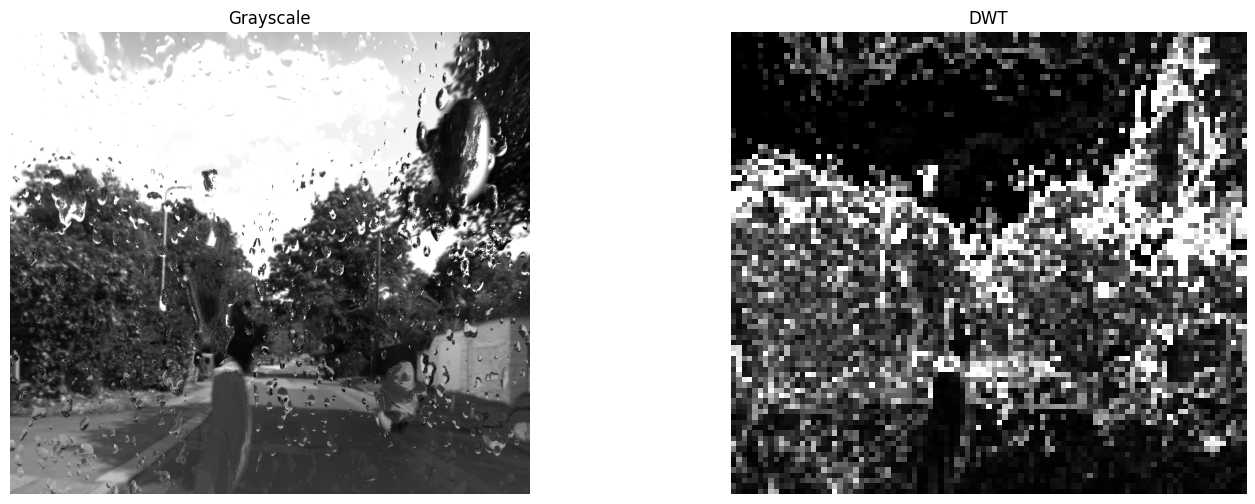

In [27]:
# Visualize results
from matplotlib import pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(17, 6))
axs[0].imshow(image, cmap='gray')
axs[1].imshow(dwt_img, cmap="gray")

axs[0].axis('off')
axs[1].axis('off')

axs[0].set_title('Grayscale')
axs[1].set_title('DWT')
plt.show()

In [30]:
def get_blur_map(image, t4 = 7):
    w = get_dwt_levels(image, 3)
    import skimage.measure
    w[1] = skimage.measure.block_reduce(w[1], (4,4), np.max)
    w[2] = skimage.measure.block_reduce(w[2], (2,2), np.max)

    blur_map = np.zeros(w[1].shape)
    for (x, y), v in np.ndenumerate(w[1]):
        w1 = w[1][x, y]
        w2 = w[2][x, y]
        w3 = w[3][x, y]
        if max(w1, w2, w3) >= t4:
            blur_map[x, y] = 1
        if w1 < t4 and w1 < w2:
            blur_map[x, y] = 0.7
    return blur_map

In [31]:
blur_map = Image.fromarray(get_blur_map(image) * 255)

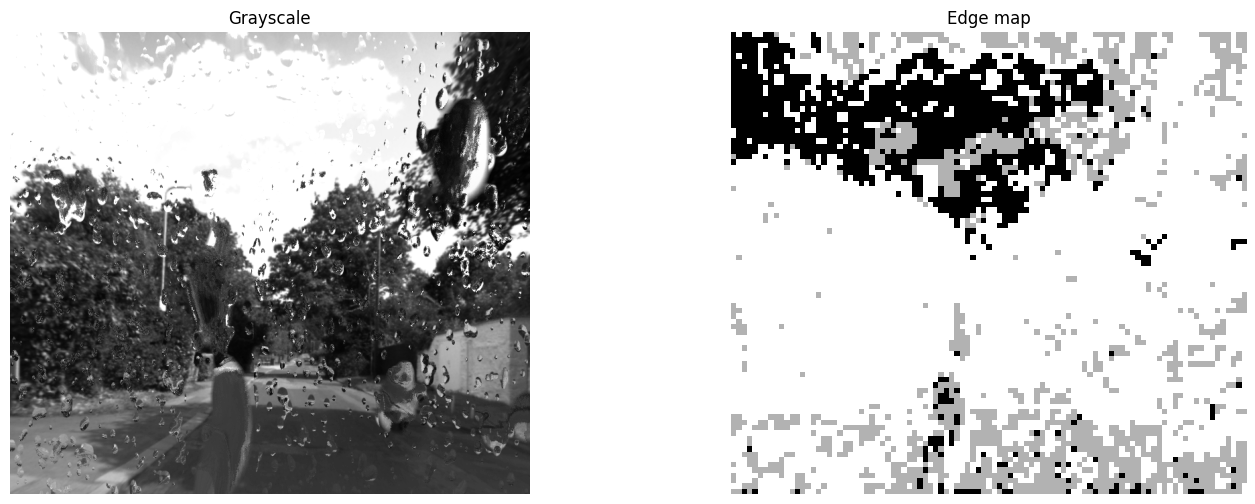

In [32]:
# Visualize results
from matplotlib import pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(17, 6))
axs[0].imshow(image, cmap='gray')
axs[1].imshow(blur_map, cmap="gray")

axs[0].axis('off')
axs[1].axis('off')

axs[0].set_title('Grayscale')
axs[1].set_title('Edge map')
plt.show()

# Gradient

In [20]:
# Kernels
sobelGx_kernel =  np.asarray([
    [ 1,  2,  1],
    [ 0,  0,  0],
    [-1, -2, -1]
]) * 1.
sobelGy_kernel = sobelGx_kernel.T

In [22]:
# Apply Gx and Gy
def image_magnitude(image):
    from scipy import signal
    Gx = signal.convolve2d(image, sobelGx_kernel)
    Gy = signal.convolve2d(image, sobelGy_kernel)
    # Calculate magnitude
    magnitude = np.sqrt(Gx ** 2 + Gy ** 2)
    return Image.fromarray(magnitude)

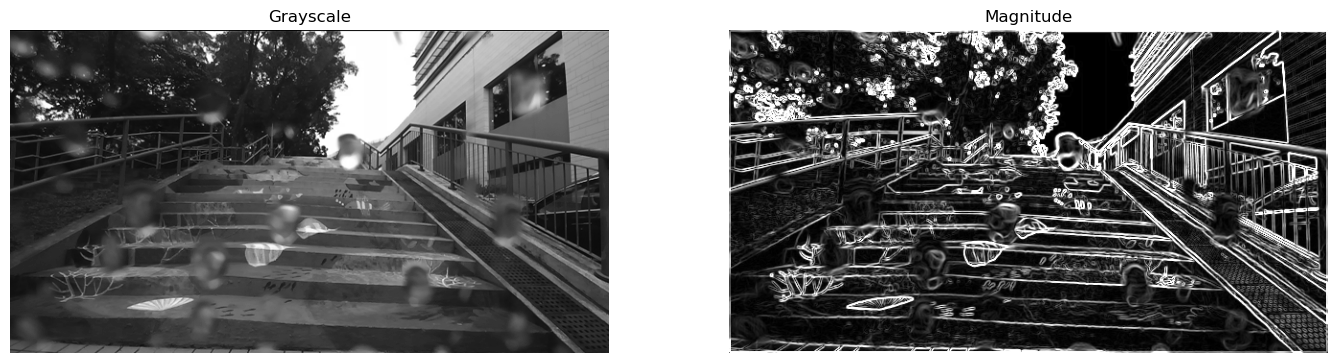

In [24]:
# Visualize results
from matplotlib import pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(17, 6))
axs[0].imshow(image, cmap='gray')
axs[1].imshow(image_magnitude(image), cmap="gray")

axs[0].axis('off')
axs[1].axis('off')

axs[0].set_title('Grayscale')
axs[1].set_title('Magnitude')
plt.show()

# Hist Normalization

In [9]:
import cv2
def equalize_hist(pil_image):
    rgb_img = np.array(pil_image.convert('RGB'))

    # convert from RGB color-space to YCrCb
    ycrcb_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2YCrCb)

    # equalize the histogram of the Y channel
    ycrcb_img[:, :, 0] = cv2.equalizeHist(ycrcb_img[:, :, 0])

    # convert back to RGB color-space from YCrCb
    equalized_img = cv2.cvtColor(ycrcb_img, cv2.COLOR_YCrCb2BGR)

    cv2.imshow('equalized_img', equalized_img)
    cv2.waitKey(0)

In [10]:
equalize_hist(image)